### Content: Pantheon, BAO, CC, Pantheon + BAO, Pantheon + CC, Pantheon + BAO + CC

In [1]:
import numpy as np
import math as m
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy
import matplotlib.pyplot as plt

# Pantheon Data

In [2]:
# Systematic Covariance Matrix
sysmtx = np.genfromtxt("sys_full_long.txt");
Csys = sysmtx.reshape([1048,1048],order='F')

# Statistical matrix
data2 = open("lcparamfull_full_long.txt",'r').readlines()
rawstat=[]
for x in data2:
    rawstat.append(x.split(' ')[5])
#ss = np.diag(rawstat)

ss = []
for i in rawstat: 
    unstrung = eval(i)
    ss.append(unstrung)
Dstat = np.diag(ss)
D = np.multiply(Dstat,Dstat)

# Full covariance matrix
C = np.zeros(shape=(1048,1048)) # Creating zero matrix

# Iterate through rows
for i in range(len(Csys)):
   # Iterate through columns
   for j in range(len(Csys[0])):
       C[i][j] = Csys[i][j] + D[i][j] 
    
# Inverse covariance matrix
invC = np.linalg.inv(C)

#### *Csys is systematic matrix*
#### *D is statistical matrix*
#### *C is full covariance matrix*
#### *invC is inverse covariance matrix*

In [4]:
# Redshift data
rawz=[]
for x in data2:
    rawz.append(x.split(' ')[2])
sz = np.array(rawz)
#unstring redshift array values
rs = []
for i in sz: 
    unstrung = eval(i)
    rs.append(unstrung)
    
# B-band apparent magnitude data 
rawmb = []
for x in data2:
    rawmb.append(x.split(' ')[4])
smb = np.array(rawmb)
#unstring mb array values
mb = []
for i in smb: 
    unstrung = eval(i)
    mb.append(unstrung)

#### *rs is an array of 1048 redshift values*
#### *mb is array of 1048 B-band apparent magnitude*

In [8]:
# Pantheon Data 

# Defining constants
K = int(input('Number of omg_m data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(65000,75000,H) #Chosen Hubble constant value (m/s/Mpc)

crs = []
for i in H0:
    for j in rs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([1048,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value

omg_m = np.linspace(0,0.5,K)
colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in omg_m:
    for j in rs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([1048,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.35 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in mb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
chidict = {}
# Obtaining chi2 value at each omg_m
chi2 = []
for i in range(K*H):
    cdrv = np.dot(invC,drv[i])
    chi2i = np.dot(drv[i].T,cdrv)
    chi2.append(chi2i)
    chidict[chi2[i]] = i

print('The minimum chi2 value is ',min(chidict.keys()))
print('The ith value for minimum chi2 is ',chidict[min(chidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(chidict[min(chidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[chidict[min(chidict.keys())]-int(chidict[min(chidict.keys())]/K)*K])

Number of omg_m data points:100
Number of H_0 data points:100
The minimum chi2 value is  1026.9364411865622
The ith value for minimum chi2 is  5058
The H0 value for minimum chi2 is  70050.50505050505
The omg_m value for minimum chi2 is  0.29292929292929293


In [9]:
# Find lowest and highest H0 and Om values 

def condition(x): return (x <= min(chidict.keys())+6.4)
output = [idx for idx, element in enumerate(chi2) if condition(element)]
#print(output)

print('The upper end H0 value is ',H0[int(max(output)/K)])
print('The lower end H0 value is ',H0[int(min(output)/K)])
print('H0 +',H0[int(max(output)/K)] - H0[int(chidict[min(chidict.keys())]/K)])
print('H0 -',H0[int(chidict[min(chidict.keys())]/K)] - H0[int(min(output)/K)])
print('The upper end omg_m value is ',omg_m[min(output)-int(min(output)/K)*K])
print('The lower end omg_m value is ',omg_m[max(output)-int(max(output)/K)*K])
print('omg_m +',omg_m[min(output)-int(min(output)/K)*K] - omg_m[chidict[min(chidict.keys())]-int(chidict[min(chidict.keys())]/K)*K])
print('omg_m -',omg_m[chidict[min(chidict.keys())]-int(chidict[min(chidict.keys())]/K)*K] - omg_m[max(output)-int(max(output)/K)*K])

The upper end H0 value is  70858.58585858587
The lower end H0 value is  69141.41414141413
H0 + 808.0808080808201
H0 - 909.0909090909117
The upper end omg_m value is  0.3434343434343435
The lower end omg_m value is  0.2474747474747475
omg_m + 0.05050505050505055
omg_m - 0.04545454545454544


## Pantheon Contours (H0 vs Om)

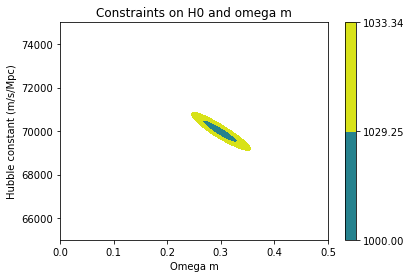

In [10]:
# Creating chi2 contours

chi = np.array(chi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, chi,levels=[1000,1029.25,1033.34]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

# BAO Data

In [11]:
# New Covariance Matrix (Cao 2019)
BaoC = np.array([[624.707, 23.729, 325.332, 8.34963, 157.386, 3.57778],
              [23.729, 5.60873, 11.6429, 2.33996, 6.39263, 0.968056],
              [325.332, 11.6429, 905.777, 29.3392, 515.271, 14.1013],
              [8.34963, 2.33996, 29.3392, 5.42327, 16.1422, 2.85334],
              [157.386, 6.39263, 515.271, 16.1422, 1375.12, 40.4327],
              [3.57778, 0.968056, 14.1013, 2.85334, 40.4327, 6.25936]])

# Inverse covariance
invBC = np.linalg.inv(BaoC)

# Measurement values for z = 0.38, 0.51, 0.61 (Order: Dm,Hz,Dm,Hz,Dm,Hz)
Aobs = np.array([1512.39, 81.2087, 1975.22, 90.9029, 2306.68, 98.9647])

#### *BaoC is covariance matrix of BAO (6)*
#### *invBC is inverse covariance matrix of BAO (6)*
#### *Aobs is vector containing 6 measurement values*

In [12]:
# BAO Data

# Redshift values of BAO (6)
Brs = np.array([0.38,0.51,0.61])

# c/H0 values for various H0
CH0 = []
for i in H0:
    ch0i = c/i 
    CH0.append(ch0i)
ch0 = np.array(CH0) # H-number of c/H0 values

# Obtaining integral values for 3 redshift values, for all omg_m values
Bcolresult = [] # List to collect all the values in the loop
Bargresult = [] # list to arrange the result in 3*K
for i in omg_m:
    for j in Brs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        Bcolresult.append(result) #3*K integral values for each redshift z value
Bargresult = np.array(Bcolresult).reshape([3,K],order='F')
# Rearrange such that each row yields 3 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.0)
Bproint = Bargresult.T 

# Obtaining dM for each omg_m value for each H0 value 
dM = []
for i in range(H):
    for j in range(K):    
        dMi = np.multiply(ch0[i],Bproint[j])
        dM.append(dMi)
# First K rows correspond omg_m from 0 to 0.5, H0 = 65000

# Obtaining Hz for each omg_m value for each H0 value
Ez = []
for i in omg_m:
    for j in Brs:
        Ezi = m.sqrt(i*(1+j)**3+(1-i))
        Ez.append(Ezi)
argEz = np.array(Ez).reshape([3,K],order='F')
proEz = argEz.T 

Hz = []
for i in H0:
    for j in range(len(proEz)):
        Hzi = np.multiply(i/1000,proEz[j])
        Hz.append(Hzi)
# First K rows correspond omg_m from 0 to 0.5, H0 = 65000

# BAO Theoretical data (DM,Hz,DM,Hz,DM,Hz)
Ath = []
for i in range(K*H):
    for j in range(3):
        Ath.append(dM[i][j])
        Ath.append(Hz[i][j])
#np.array(Ath).shape
argAth = np.array(Ath).reshape([6,K*H],order='F')
proAth = argAth.T
# Each row consists Ath(6) First K rows correspond omg_m from 0 to 0.5, H0 = 65000

# BAO Residual Vector
ARV = []
for i in range(len(proAth)):
    Arvi = np.subtract(proAth[i],Aobs)
    ARV.append(Arvi)
Arv = np.array(ARV)

#chi2 (Dm Hz)
Bchidict = {}
Bchi2 = []
for i in range(len(Arv)):
    BcArv = np.dot(invBC,Arv[i])
    Bchi2i = np.dot(Arv[i].T,BcArv)
    Bchi2.append(Bchi2i)
    Bchidict[Bchi2[i]] = i

print('The minimum chi2 value is ',min(Bchidict.keys()))
print('The ith value for minimum chi2 is ',Bchidict[min(Bchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Bchidict[min(Bchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[Bchidict[min(Bchidict.keys())]-int(Bchidict[min(Bchidict.keys())]/K)*K])

The minimum chi2 value is  2.063009236358911
The ith value for minimum chi2 is  1572
The H0 value for minimum chi2 is  66515.15151515152
The omg_m value for minimum chi2 is  0.36363636363636365


In [37]:
# rs/Dv (z=0.106 Beutler et al.)
# Dv = ((cz/H0)*(Dm^2/Ez))^1/3

z1 = 0.106
czh1 = [c*z1/i for i in H0]
Ez1 = []
for i in omg_m:
    Ez1i = m.sqrt(i*(1+z1)**3+(1-i))
    Ez1.append(Ez1i)

czhE1 = []
for i in czh1:
    for j in Ez1:
        czhE1i = i/j
        czhE1.append(czhE1i)

# Obtaining dM
z1result = []
for i in omg_m:
    def F(x):
        return 1/m.sqrt(i*(1+x)**3+(1-i))
    result, error = quad(F, 0, z1)  
    z1result.append(result) # Integral of 1/Ez

dM1 = []
for i in H0:
    for j in z1result:
        dM1i = (c*j/i)**2
        dM1.append(dM1i) # [(c/H0)*Integral]^2

Dv1i = np.multiply(czhE1,dM1)
Ath1 = [147.6/(i**(1/3)) for i in Dv1i]
#print(np.array(rsDv).shape)

# List of chi2 values for rs/Dv
A1 = [(i-0.336)**2 for i in Ath1]
chi1 = [i/(0.015**2) for i in A1]

# Dv (z=0.15 Ross et al.)
# Dv = ((cz/H0)*(Dm^2/Ez))^1/3

z2 = 0.15
czh2 = [c*z2/i for i in H0]
Ez2 = []
for i in omg_m:
    Ez2i = m.sqrt(i*(1+z2)**3+(1-i))
    Ez2.append(Ez2i)

czhE2 = []
for i in czh2:
    for j in Ez2:
        czhE2i = i/j
        czhE2.append(czhE2i)

# Obtaining dM
z2result = []
for i in omg_m:
    def F(x):
        return 1/m.sqrt(i*(1+x)**3+(1-i))
    result, error = quad(F, 0, z2) #Generate 1 integral result for each z-value 
    z2result.append(result) #1048*10 integral values for each redshift z value

dM2 = []
for i in H0:
    for j in z2result:
        dM2i = (c*j/i)**2
        dM2.append(dM2i)

Dv2i = np.multiply(czhE2,dM2)
Ath2 = [(i**(1/3)) for i in Dv2i]

# List of chi2 values for Dv
A2 = [(i-664)**2 for i in Ath2]
chi02 = [i/(25**2) for i in A2]

# Dv (z=1.52 Ata et al.)
# Dv = ((cz/H0)*(Dm^2/Ez))^1/3

z3 = 1.52
czh3 = [c*z3/i for i in H0]
Ez3 = []
for i in omg_m:
    Ez3i = m.sqrt(i*(1+z3)**3+(1-i))
    Ez3.append(Ez3i)

czhE3 = []
for i in czh3:
    for j in Ez3:
        czhE3i = i/j
        czhE3.append(czhE3i)

# Obtaining dM
z3result = []
for i in omg_m:
    def F(x):
        return 1/m.sqrt(i*(1+x)**3+(1-i))
    result, error = quad(F, 0, z3) #Generate 1 integral result for each z-value 
    z3result.append(result) #1048*10 integral values for each redshift z value

dM3 = []
for i in H0:
    for j in z3result:
        dM3i = (c*j/i)**2
        dM3.append(dM3i)

Dv3i = np.multiply(czhE3,dM3)
Ath3 = [(i**(1/3)) for i in Dv3i]

# List of chi2 values for Dv
A3 = [(i-3843)**2 for i in Ath3]
chi3 = [i/(147**2) for i in A3]

# dM^0.3*dH^0.7/rs (z=2.33 Bautista et al.)
# DH = c/H(z)
# H(z) = H0[sqrt(omg_m*(1+z)^3+omg_l)]
# DM = (c/H0)*Integral(1/Ez)

z4 = 2.33

# Obtaining dH
dH = []
for i in H0:
    for j in omg_m:
        dHi = c/(i*m.sqrt(j*(1+z4)**3+(1-j)))
        dH.append(dHi)
dH4 = [i**0.7 for i in dH]

# Obtaining dM
z4result = []
for i in omg_m:
    def F(x):
        return 1/(m.sqrt(i*(1+x)**3+(1-i)))
    result, error = quad(F, 0, z4)
    z4result.append(result) # Integral of 1/Ez 
    
dM4 = []
for i in H0:
    for j in z4result:
        dM4i = (c*j/i)**0.3
        dM4.append(dM4i) # dM^(0.3)
        
dMH = np.multiply(dM4,dH4)
Ath4 = [i/147.6 for i in dMH]

# List of chi2 values for dM^0.3*dH^0.7/rs
A4 = [(i-13.94)**2 for i in Ath4]
chi4 = [i/(0.35**2) for i in A4]

# c/(rs*Hz) (z=2.36 Font-Ribera et al.)
z5 = 2.36

Ath5 = []
for i in H0:
    for j in omg_m:
        crsHzi = c/(147.6*i*m.sqrt(j*(1+z5)**3+(1-j)))
        Ath5.append(crsHzi)

# List of chi2 values for c/(rs*Hz)
A5 = [(i-9)**2 for i in Ath5]
chi5 = [i/(0.3**2) for i in A5]


In [38]:
chi12 = np.add(chi1, chi02)
chi123 = np.add(chi12, chi3)
chi1234 = np.add(chi123, chi4)
xBchi2 = np.add(chi1234, chi5)

CBchi2 = np.add(Bchi2,xBchi2)
CBchidict = {}
for i in range(len(CBchi2)):
    CBchidict[CBchi2[i]] = i
    
print('The minimum chi2 value is ',min(CBchidict.keys()))
print('The ith value for minimum chi2 is ',CBchidict[min(CBchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(CBchidict[min(CBchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[CBchidict[min(CBchidict.keys())]-int(CBchidict[min(CBchidict.keys())]/K)*K])

The minimum chi2 value is  8.077548996657455
The ith value for minimum chi2 is  3756
The H0 value for minimum chi2 is  68737.37373737374
The omg_m value for minimum chi2 is  0.2828282828282829


In [15]:
# Find lowest and highest H0 and Om values 

def condition(x): return (x <= min(CBchidict.keys())+6.4)
output = [idx for idx, element in enumerate(CBchi2) if condition(element)]
#print(output)

print('The upper end H0 value is ',H0[int(max(output)/K)])
print('The lower end H0 value is ',H0[int(min(output)/K)])
print('H0 +',H0[int(max(output)/K)] - H0[int(CBchidict[min(CBchidict.keys())]/K)])
print('H0 -',H0[int(CBchidict[min(CBchidict.keys())]/K)] - H0[int(min(output)/K)])
print('The upper end omg_m value is ',omg_m[min(output)-int(min(output)/K)*K])
print('The lower end omg_m value is ',omg_m[max(output)-int(max(output)/K)*K])
print('omg_m +',omg_m[min(output)-int(min(output)/K)*K] - omg_m[CBchidict[min(CBchidict.keys())]-int(CBchidict[min(CBchidict.keys())]/K)*K])
print('omg_m -',omg_m[CBchidict[min(CBchidict.keys())]-int(CBchidict[min(CBchidict.keys())]/K)*K] - omg_m[max(output)-int(max(output)/K)*K])

The upper end H0 value is  70959.59595959596
The lower end H0 value is  66414.14141414141
H0 + 2222.222222222219
H0 - 2323.232323232325
The upper end omg_m value is  0.32323232323232326
The lower end omg_m value is  0.2474747474747475
omg_m + 0.04040404040404039
omg_m - 0.03535353535353539


# BAO Contour

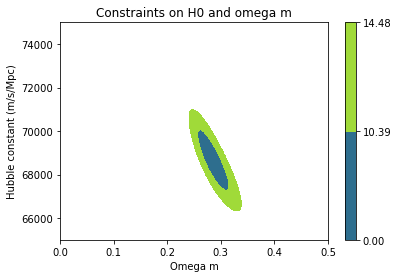

In [16]:
# Creating Bchi2 contours

CBchi = np.array(CBchi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, CBchi,levels=[0,10.39,14.48]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

# Pantheon + BAO

In [17]:
# Likelihood from Pantheon chi2
Lpan = []
for i in chi2:
    Lpani = np.exp(-i/2)
    Lpan.append(Lpani)
    
# Likelihood from BAO chi2    
LBAO = []
for i in CBchi2:
    LBAOi = np.exp(-i/2)
    LBAO.append(LBAOi)

# Combined likelihood (Pantheon+BAO)    
LpanBAO = np.multiply(Lpan,LBAO)
panBAOdict = {}
for i in range(len(LpanBAO)):
    panBAOdict[LpanBAO[i]] = i
    
print('The maximum likelihood value is ',max(panBAOdict.keys()))
print('The ith value for maximum likelihood is ',panBAOdict[max(panBAOdict.keys())])
print('The H0 value for maximum likelihood is ',H0[int(panBAOdict[max(panBAOdict.keys())]/K)])
print('The omg_m value for maximum likelihood is ',omg_m[panBAOdict[max(panBAOdict.keys())]-int(panBAOdict[max(panBAOdict.keys())]/K)*K])

The maximum likelihood value is  5.355190473608896e-227
The ith value for maximum likelihood is  5353
The H0 value for maximum likelihood is  70353.53535353535
The omg_m value for maximum likelihood is  0.2676767676767677


In [19]:
# Finding minimum chi2

addpBchi = np.add(chi2,CBchi2)

pBdict = {}
for i in range(len(addpBchi)):
    pBdict[addpBchi[i]] = i

print('The minimum chi2 value is ',min(pBdict.keys()))
print('The ith value for minimum chi2 is ',pBdict[min(pBdict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(pBdict[min(pBdict.keys())]/K)])
print('The w value for minimum chi2 is ',omg_m[pBdict[min(pBdict.keys())]-int(pBdict[min(pBdict.keys())]/K)*K])

The minimum chi2 value is  1042.0174996741598
The ith value for minimum chi2 is  5353
The H0 value for minimum chi2 is  70353.53535353535
The w value for minimum chi2 is  0.2676767676767677


# Pantheon + BAO Contour

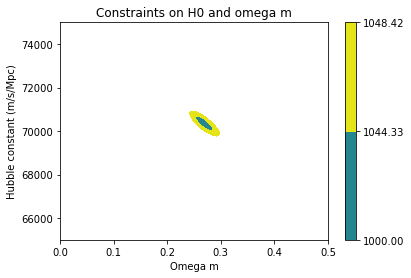

In [20]:
# Plotting contours using chi2 addition

addpBchi = np.add(chi2,CBchi2)

pBchi = np.array(addpBchi).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, pBchi,levels=[1000,1044.33,1048.42]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

In [21]:
# Find lowest and highest H0 and Om values 

pBchidict = {}
for i in range(len(addpBchi)):
    pBchidict[addpBchi[i]] = i

def condition(x): return (x <= min(pBchidict.keys())+6.4)
output = [idx for idx, element in enumerate(addpBchi) if condition(element)]
#print(output)

print('The upper end H0 value is ',H0[int(max(output)/K)])
print('The lower end H0 value is ',H0[int(min(output)/K)])
print('H0 +',H0[int(max(output)/K)] - H0[int(pBchidict[min(pBchidict.keys())]/K)])
print('H0 -',H0[int(pBchidict[min(pBchidict.keys())]/K)] - H0[int(min(output)/K)])
print('The upper end omg_m value is ',omg_m[min(output)-int(min(output)/K)*K])
print('The lower end omg_m value is ',omg_m[max(output)-int(max(output)/K)*K])
print('omg_m +',omg_m[min(output)-int(min(output)/K)*K] - omg_m[pBchidict[min(pBchidict.keys())]-int(pBchidict[min(pBchidict.keys())]/K)*K])
print('omg_m -',omg_m[pBchidict[min(pBchidict.keys())]-int(pBchidict[min(pBchidict.keys())]/K)*K] - omg_m[max(output)-int(max(output)/K)*K])

The upper end H0 value is  70858.58585858587
The lower end H0 value is  69848.48484848485
H0 + 505.0505050505162
H0 - 505.05050505050167
The upper end omg_m value is  0.2828282828282829
The lower end omg_m value is  0.25252525252525254
omg_m + 0.015151515151515194
omg_m - 0.015151515151515138


# CC Data

In [22]:
# Cosmic Chronometer Value Storage (Observational)

# 31 Redshift values for CC
ccz = np.array([0.07, 0.09, 0.12, 0.17, 0.179, 0.199, 0.20, 0.27, 0.28, 0.352, 0.3802, 
             0.4, 0.4004, 0.4247, 0.4479, 0.47, 0.4783, 0.48, 0.593, 0.68, 0.781,
            0.875, 0.88, 0.90, 1.037, 1.3, 1.363, 1.43, 1.53, 1.75, 1.965])

# 31 Hz values for CC
ccHz = np.array([69, 69, 68.6, 83, 75, 75, 72.9, 77, 88.8, 83, 83, 
              95, 77, 87.1, 92.8, 89, 80.9, 97, 104, 92, 105, 
              125, 90, 117, 154, 168, 160, 177, 140, 202, 186.5])

# 31 Sigma H values for CC
sigH = np.array([19.6, 12, 26.2, 8, 4, 5, 29.6, 14, 36.6, 14, 13.5,
                17, 10.2, 11.2, 12.9, 50, 9, 62, 13, 8, 12,
                17, 40, 23, 20, 17, 33.6, 18, 14, 40, 50.4])

#### *ccz is redshift values of CC*
#### *ccHz is Hz values of CC*
#### *sigH is the sigma values of CC*

In [23]:
# Obtaining Ez value for each Omg_m 

ccEz = []
for i in omg_m:
    for j in ccz:
        ccEzi = m.sqrt(i*(1+j)**3+(1-i))
        ccEz.append(ccEzi)
argccEz = np.array(ccEz).reshape([31,K],order='F')
proccEz = argccEz.T 

# Obtaining Ath value for each H0 and Omg_m 
ccAth = []
for i in H0:
    for j in range(len(proccEz)):
        ccAthi = (i/1000)*proccEz[j]
        ccAth.append(ccAthi)

# Obtaining (Ath-Aobs)^2 
Asub = []
for i in range(K*H):
    Asubi = ccAth[i]-ccHz
    Asub.append(Asubi)
A2 = [i**2 for i in Asub]

# Defining sigma_H square (31 values)
sigH2 = [i**2 for i in sigH]

Asig = []
for i in range(K*H):
    Asigi = A2[i]/sigH2
    Asig.append(Asigi)

Cchidict ={}
Cchi2 = []
for i in range(K*H):
    Cchi2i = sum(Asig[i])
    Cchi2.append(Cchi2i)
    Cchidict[Cchi2[i]] = i

print('The minimum chi2 value is ',min(Cchidict.keys()))
print('The ith value for minimum chi2 is ',Cchidict[min(Cchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Cchidict[min(Cchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[Cchidict[min(Cchidict.keys())]-int(Cchidict[min(Cchidict.keys())]/K)*K])

The minimum chi2 value is  14.506658312632347
The ith value for minimum chi2 is  3263
The H0 value for minimum chi2 is  68232.32323232324
The omg_m value for minimum chi2 is  0.31818181818181823


In [24]:
# Find lowest and highest H0 and Om values 

def condition(x): return (x <= min(Cchidict.keys())+6.4)
output = [idx for idx, element in enumerate(Cchi2) if condition(element)]
#print(output)

print('The upper end H0 value is ',H0[int(max(output)/K)])
print('The lower end H0 value is ',H0[int(min(output)/K)])
print('H0 +',H0[int(max(output)/K)] - H0[int(Cchidict[min(Cchidict.keys())]/K)])
print('H0 -',H0[int(Cchidict[min(Cchidict.keys())]/K)] - H0[int(min(output)/K)])
print('The upper end omg_m value is ',omg_m[min(output)-int(min(output)/K)*K])
print('The lower end omg_m value is ',omg_m[max(output)-int(max(output)/K)*K])
print('omg_m +',omg_m[min(output)-int(min(output)/K)*K] - omg_m[Cchidict[min(Cchidict.keys())]-int(Cchidict[min(Cchidict.keys())]/K)*K])
print('omg_m -',omg_m[Cchidict[min(Cchidict.keys())]-int(Cchidict[min(Cchidict.keys())]/K)*K] - omg_m[max(output)-int(max(output)/K)*K])

The upper end H0 value is  75000.0
The lower end H0 value is  65000.0
H0 + 6767.676767676763
H0 - 3232.323232323237
The upper end omg_m value is  0.30303030303030304
The lower end omg_m value is  0.2474747474747475
omg_m + -0.015151515151515194
omg_m - 0.07070707070707075


# CC Contour

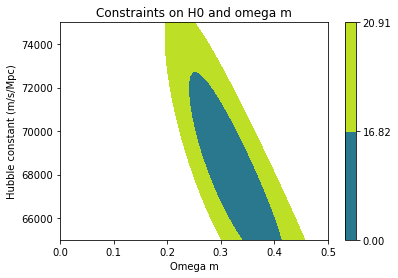

In [26]:
# Plotting contours using chi2 addition

Cchi = np.array(Cchi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, Cchi,levels=[0,16.82,20.91]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

# Pantheon + CC

In [27]:
# Likelihood from Pantheon chi2
Lpan = []
for i in chi2:
    Lpani = np.exp(-i/2)
    Lpan.append(Lpani)
    
# Likelihood from CC chi2    
LCC = []
for i in Cchi2:
    LCCi = np.exp(-i/2)
    LCC.append(LCCi)

# Combined likelihood (Pantheon+CC)    
LpanCC = np.multiply(Lpan,LCC)
panCCdict = {}
for i in range(len(LpanCC)):
    panCCdict[LpanCC[i]] = i
    
print('The maximum likelihood value is ',max(panCCdict.keys()))
print('The ith value for maximum likelihood is ',panCCdict[max(panCCdict.keys())])
print('The H0 value for maximum likelihood is ',H0[int(panCCdict[max(panCCdict.keys())]/K)])
print('The omg_m value for maximum likelihood is ',omg_m[panCCdict[max(panCCdict.keys())]-int(panCCdict[max(panCCdict.keys())]/K)*K])

The maximum likelihood value is  5.84176625361712e-227
The ith value for maximum likelihood is  5058
The H0 value for maximum likelihood is  70050.50505050505
The omg_m value for maximum likelihood is  0.29292929292929293


In [29]:
# Finding minimum chi2

addpCchi = np.add(chi2,Cchi2)

pCdict = {}
for i in range(len(addpCchi)):
    pCdict[addpCchi[i]] = i

print('The minimum chi2 value is ',min(pCdict.keys()))
print('The ith value for minimum chi2 is ',pCdict[min(pCdict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(pCdict[min(pCdict.keys())]/K)])
print('The w value for minimum chi2 is ',omg_m[pCdict[min(pCdict.keys())]-int(pCdict[min(pCdict.keys())]/K)*K])

The minimum chi2 value is  1041.8435658356927
The ith value for minimum chi2 is  5058
The H0 value for minimum chi2 is  70050.50505050505
The w value for minimum chi2 is  0.29292929292929293


# Pantheon + CC Contour

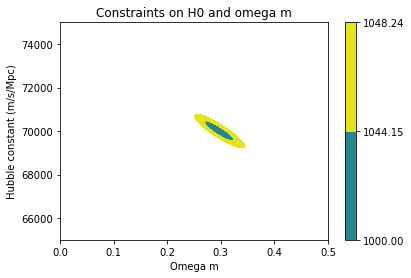

In [31]:
# Plotting contours using chi2 addition

addpCchi = np.add(chi2,Cchi2)

pCchi = np.array(addpCchi).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, pCchi,levels=[1000,1044.15,1048.24]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

In [30]:
# Find lowest and highest H0 and Om values 

pCchidict = {}
for i in range(len(addpCchi)):
    pCchidict[addpCchi[i]] = i

def condition(x): return (x <= min(pCchidict.keys())+6.4)
output = [idx for idx, element in enumerate(addpCchi) if condition(element)]
#print(output)

print('The upper end H0 value is ',H0[int(max(output)/K)])
print('The lower end H0 value is ',H0[int(min(output)/K)])
print('H0 +',H0[int(max(output)/K)] - H0[int(pCchidict[min(pCchidict.keys())]/K)])
print('H0 -',H0[int(pCchidict[min(pCchidict.keys())]/K)] - H0[int(min(output)/K)])
print('The upper end omg_m value is ',omg_m[min(output)-int(min(output)/K)*K])
print('The lower end omg_m value is ',omg_m[max(output)-int(max(output)/K)*K])
print('omg_m +',omg_m[min(output)-int(min(output)/K)*K] - omg_m[pCchidict[min(pCchidict.keys())]-int(pCchidict[min(pCchidict.keys())]/K)*K])
print('omg_m -',omg_m[pCchidict[min(pCchidict.keys())]-int(pCchidict[min(pCchidict.keys())]/K)*K] - omg_m[max(output)-int(max(output)/K)*K])

The upper end H0 value is  70757.57575757576
The lower end H0 value is  69242.42424242424
H0 + 707.070707070714
H0 - 808.0808080808056
The upper end omg_m value is  0.3383838383838384
The lower end omg_m value is  0.2575757575757576
omg_m + 0.04545454545454547
omg_m - 0.035353535353535304


# Pantheon + BAO + CC

In [32]:
# Likelihood from Pantheon chi2
Lpan = []
for i in chi2:
    Lpani = np.exp(-i/2)
    Lpan.append(Lpani)
    
# Likelihood from BAO chi2    
LBAO = []
for i in CBchi2:
    LBAOi = np.exp(-i/2)
    LBAO.append(LBAOi)
    
# Likelihood from CC chi2    
LCC = []
for i in Cchi2:
    LCCi = np.exp(-i/2)
    LCC.append(LCCi)

# Combined likelihood (Pantheon+CC)    
LpanBAO = np.multiply(Lpan,LBAO)
LpanBAOCC = np.multiply(LpanBAO,LCC)
panBAOCCdict = {}
for i in range(len(LpanBAOCC)):
    panBAOCCdict[LpanBAOCC[i]] = i
    
print('The maximum likelihood value is ',max(panBAOCCdict.keys()))
print('The ith value for maximum likelihood is ',panBAOCCdict[max(panBAOCCdict.keys())])
print('The H0 value for maximum likelihood is ',H0[int(panBAOCCdict[max(panBAOCCdict.keys())]/K)])
print('The omg_m value for maximum likelihood is ',omg_m[panBAOCCdict[max(panBAOCCdict.keys())]-int(panBAOCCdict[max(panBAOCCdict.keys())]/K)*K])

The maximum likelihood value is  2.4355631092236484e-230
The ith value for maximum likelihood is  5254
The H0 value for maximum likelihood is  70252.52525252526
The omg_m value for maximum likelihood is  0.27272727272727276


In [34]:
# Finding minimum chi2

addpBchi = np.add(chi2,CBchi2)
addpBCchi = np.add(addpBchi, Cchi2)

pBCdict = {}
for i in range(len(addpBCchi)):
    pBCdict[addpBCchi[i]] = i

print('The minimum chi2 value is ',min(pBCdict.keys()))
print('The ith value for minimum chi2 is ',pBCdict[min(pBCdict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(pBCdict[min(pBCdict.keys())]/K)])
print('The w value for minimum chi2 is ',omg_m[pBCdict[min(pBCdict.keys())]-int(pBCdict[min(pBCdict.keys())]/K)*K])

The minimum chi2 value is  1057.4087868049537
The ith value for minimum chi2 is  5254
The H0 value for minimum chi2 is  70252.52525252526
The w value for minimum chi2 is  0.27272727272727276


# Pantheon + BAO + CC Contour

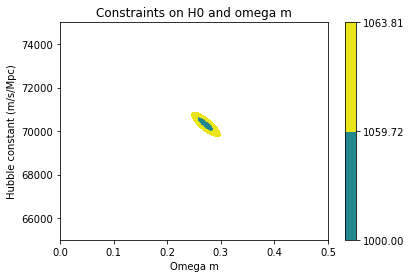

In [36]:
# Plotting contours using chi2 addition

addpBchi = np.add(chi2,CBchi2)
addpBCchi = np.add(addpBchi,Cchi2)

pBCchi = np.array(addpBCchi).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, pBCchi,levels=[1000,1059.72,1063.81]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

In [35]:
# Find lowest and highest H0 and Om values 

pBCchidict = {}
for i in range(len(addpBCchi)):
    pBCchidict[addpBCchi[i]] = i

def condition(x): return (x <= min(pBCchidict.keys())+6.4)
output = [idx for idx, element in enumerate(addpBCchi) if condition(element)]
#print(output)

print('The upper end H0 value is ',H0[int(max(output)/K)])
print('The lower end H0 value is ',H0[int(min(output)/K)])
print('H0 +',H0[int(max(output)/K)] - H0[int(pBCchidict[min(pBCchidict.keys())]/K)])
print('H0 -',H0[int(pBCchidict[min(pBCchidict.keys())]/K)] - H0[int(min(output)/K)])
print('The upper end omg_m value is ',omg_m[min(output)-int(min(output)/K)*K])
print('The lower end omg_m value is ',omg_m[max(output)-int(max(output)/K)*K])
print('omg_m +',omg_m[min(output)-int(min(output)/K)*K] - omg_m[pBCchidict[min(pBCchidict.keys())]-int(pBCchidict[min(pBCchidict.keys())]/K)*K])
print('omg_m -',omg_m[pBCchidict[min(pBCchidict.keys())]-int(pBCchidict[min(pBCchidict.keys())]/K)*K] - omg_m[max(output)-int(max(output)/K)*K])

The upper end H0 value is  70858.58585858587
The lower end H0 value is  69747.47474747474
H0 + 606.0606060606078
H0 - 505.0505050505162
The upper end omg_m value is  0.29292929292929293
The lower end omg_m value is  0.25252525252525254
omg_m + 0.020202020202020166
omg_m - 0.02020202020202022
